In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

In [2]:
df = pd.read_csv('/Users/aronnyberg/code/quanty2/gateio_data/aggregated_trade_data.csv')
#df = pd.read_csv('/Users/aronnyberg/code/quanty2/gateio_data/aggregated_trade_data_23season.csv')
token_lookup = pd.read_csv('/Users/aronnyberg/code/quanty2/football_strat/fanTokens.csv')
matches_old = pd.read_csv("/Users/aronnyberg/code/quanty2/football_strat/matchdays - Sheet1.csv")
btc_rets = pd.read_csv("/Users/aronnyberg/code/quanty2/gateio_data//btc_daily_rets.csv")
#btc_rets = pd.read_csv("/Users/aronnyberg/code/quanty2/gateio_data/btc_daily_rets_23season.csv")
matches = pd.read_csv("/Users/aronnyberg/code/quanty2/football_strat/matchdays_new.csv")
#matches = pd.read_csv("/Users/aronnyberg/code/quanty2/football_strat/matchdays_2023season.csv")

In [3]:

#getting 'Club'/name variable into matches df
matches['Club'] = matches['tickers'].map(token_lookup[['ticker','Name']].set_index('ticker').to_dict()['Name'])

In [4]:
#not being used
#matches_old = pd.read_csv("/Users/aronnyberg/code/quanty2/matchdays - Sheet1.csv")
btc_rets

,timestamp,vwap
0,2018-01-01,-0.020909
1,2018-01-02,0.030311
2,2018-01-03,0.075158
3,2018-01-04,-0.006393
4,2018-01-05,0.074566
...,...,...
2002,2023-06-26,-0.012149
2003,2023-06-27,0.010533
2004,2023-06-28,-0.010600
2005,2023-06-29,0.006773


In [8]:
df = df.sort_values(['ticker', 'timestamp'])
#df.set_index('timestamp', inplace=True)

In [9]:
token_lookup['ticker'] = [str(i)+"_USDT"  for i in token_lookup['ticker']]

In [10]:
matches['Date'] = matches['matchdays']
#matches['matchdays']

In [11]:
matches = matches[[len(i)>1 for i in matches['Date']]]
splits = [i.split(" ") for i in matches['Date']]
months = [datetime.strptime(i[1], '%b').month for i in splits]
days = [i[2].split(",")[0] for i in splits]
years = [i[3].split(",")[0] for i in splits]
matches['Day'] = days
matches['Month'] = months
matches['Year'] = years

In [12]:
matches['DateTime'] = matches['Day'].astype(str)+"/"+matches['Month'].astype(str)+"/"+matches['Year'].astype(str)
matches['DateTime'] = pd.to_datetime(matches['DateTime'], format= "%d/%m/%Y")
matches['MatchDay'] = 1

In [13]:
matches = matches.set_index('Club').join(token_lookup.set_index('Name'))

In [14]:
btc_rets['timestamp'] = pd.to_datetime(btc_rets['timestamp'])
btc_rets.set_index('timestamp',inplace=True)
btc_rets.rename(columns={'vwap':'btc'}, inplace=True)
btc_rets['btc'] = btc_rets['btc'].rolling(2).sum()

In [19]:
df['ticker'].drop_duplicates()

6493625        ACM_USDT
19599625       AFC_USDT
22717763       ALA_USDT
19762718        AM_USDT
13384310       ARG_USDT
11057520       ASM_USDT
6686946        ASR_USDT
17250780     ATLAS_USDT
5582121        ATM_USDT
15388341       BFC_USDT
4211892       CITY_USDT
18165661       FOR_USDT
11894489    GALFAN_USDT
8262791       GALO_USDT
11367294       GOZ_USDT
17795535      IBFK_USDT
3181420      INTER_USDT
12231339       JUV_USDT
15193386     LAZIO_USDT
11994131       LEV_USDT
20034579     MENGO_USDT
12613214       NAP_USDT
4956882       NAVI_USDT
13929322        OG_USDT
13921379     PORTO_USDT
2012165        POR_USDT
11435513       PSG_USDT
20140268       RFT_USDT
6505531     SANTOS_USDT
19953473    SAUBER_USDT
23160959      SCCP_USDT
15253576       SFP_USDT
21942928      SPFC_USDT
8547210        TRA_USDT
Name: ticker, dtype: object

In [20]:
agg_df = pd.DataFrame()
for each_club in df['ticker'].drop_duplicates():
    
    #filter to one club to avoid pct_change between clubs
    club_df = df.loc[df['ticker'] == each_club]
    club_df['timestamp'] = pd.to_datetime(club_df['timestamp'])
    club_df.set_index('timestamp', inplace=True)
    club_df = club_df['vwap'].pct_change().resample('d').sum()
    returns = pd.DataFrame(-club_df.rolling(2).sum())
    returns['ticker'] = each_club

    #reset index so merge sets it
    returns.reset_index(inplace=True)
    merge_df = pd.merge(returns, matches,  how='left', left_on=['timestamp','ticker'], right_on = ['DateTime','ticker'])
    merge_df = merge_df.dropna(axis=0)
    merge_df = merge_df[['timestamp','vwap','ticker']]
    
    merge_df.set_index('timestamp', inplace=True)
    merge_df.drop_duplicates(inplace=True)
    
    merge_df = pd.concat([merge_df, btc_rets], axis=1)
    
    agg_df = pd.concat([agg_df, merge_df], axis=0)

/var/folders/jq/bnrgxd_s43d7nggw471h_rtm0000gn/T/ipykernel_1633/2522852575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  club_df['timestamp'] = pd.to_datetime(club_df['timestamp'])
/var/folders/jq/bnrgxd_s43d7nggw471h_rtm0000gn/T/ipykernel_1633/2522852575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  club_df['timestamp'] = pd.to_datetime(club_df['timestamp'])
/var/folders/jq/bnrgxd_s43d7nggw471h_rtm0000gn/T/ipykernel_1633/2522852575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a

In [21]:
#+ becuase strategy returns are short returns
agg_df['strat_rets'] = agg_df['btc']+agg_df['vwap']

In [22]:
agg_df = agg_df.dropna()

In [23]:
agg_df.sort_index(inplace=True)

<AxesSubplot:xlabel='timestamp'>

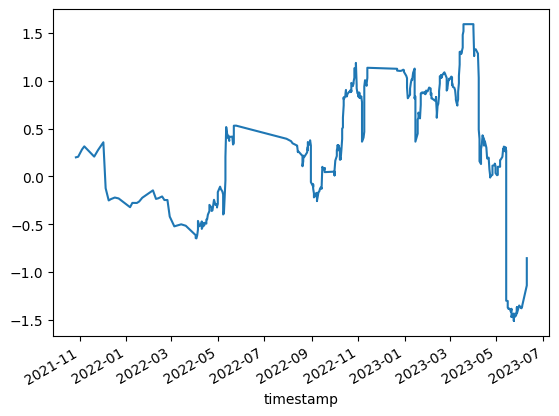

In [24]:
agg_df['strat_rets'].cumsum().plot()

<AxesSubplot:xlabel='timestamp'>

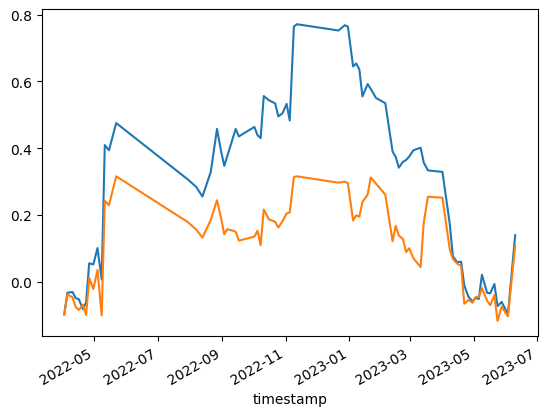

In [25]:
agg_df[agg_df['ticker'] == 'CITY_USDT']['vwap'].cumsum().plot()
agg_df[agg_df['ticker'] == 'CITY_USDT']['strat_rets'].cumsum().plot()

In [26]:
# (-agg_df[agg_df['ticker'] == 'CITY_USDT']['vwap'].cumsum()).plot()
# agg_df[agg_df['ticker'] == 'CITY_USDT']['btc'].cumsum().plot()

In [27]:
agg_df.groupby('ticker').mean()

,vwap,btc,strat_rets
ticker,,,
ACM_USDT,0.003620,0.003862,0.007482
AFC_USDT,0.004041,-0.006614,-0.002573
ASR_USDT,-0.015373,-0.002634,-0.018007
ATM_USDT,0.005857,0.004931,0.010788
CITY_USDT,0.001860,-0.000426,0.001434
INTER_USDT,0.005580,0.002730,0.008310
LAZIO_USDT,-0.002895,-0.008452,-0.011347


In [28]:
agg_df['vwap'].mean()

-0.000291138106669026

In [29]:
agg_df['strat_rets'].mean()

-0.0019307203588065658

<AxesSubplot:xlabel='timestamp'>

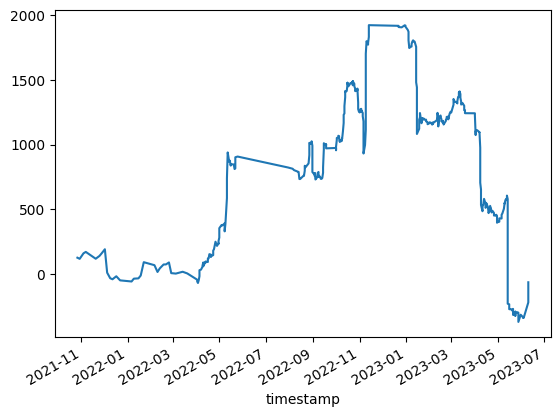

In [30]:
(agg_df['vwap']*500).cumsum().plot()

<AxesSubplot:xlabel='timestamp'>

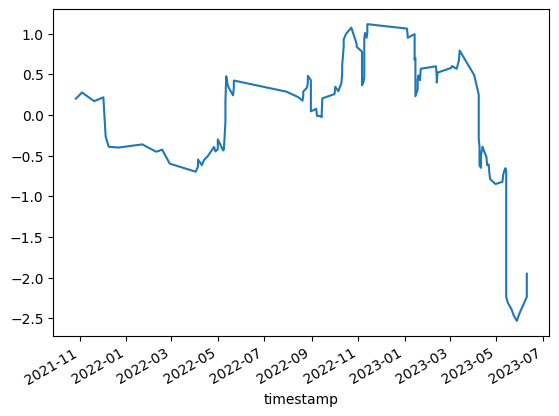

In [31]:
agg_df[agg_df['vwap'].abs() > 0.05]['strat_rets'].cumsum().plot()

<AxesSubplot:xlabel='timestamp'>

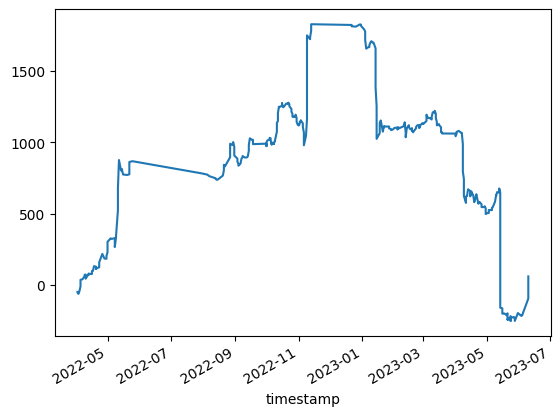

In [32]:
(agg_df[agg_df['ticker']!='LAZIO_USDT']['vwap']*500).cumsum().plot()

In [25]:
matches.index.drop_duplicates()

Index(['AC Milan', 'Arsenal', 'Athletico Madrid', 'Barcelona', 'Lazio',
       'Manchester City', 'Roma'],
      dtype='object')

In [26]:
agg_df.groupby('ticker').mean()

,vwap,btc,strat_rets
ticker,,,
ACM_USDT,-0.013431,-0.003166,-0.016597
AFC_USDT,0.038141,-0.002948,0.035193
ASR_USDT,-0.005416,-0.007997,-0.013413
ATM_USDT,0.022552,-0.003090,0.019461
CITY_USDT,0.021151,-0.011967,0.009184
LAZIO_USDT,-0.026477,-0.003277,-0.029754


In [27]:
agg_df.groupby('ticker').std()['vwap']/np.sqrt(agg_df.groupby('ticker').count()['vwap'])

NameError: name 'np' is not defined

In [28]:
(agg_df.groupby('ticker').mean()['vwap'])/(agg_df.groupby('ticker').std()['vwap']/np.sqrt(agg_df.groupby('ticker').count()['vwap']))

NameError: name 'np' is not defined

In [30]:
agg_df

,vwap,ticker,btc,strat_rets
timestamp,,,,
2023-08-06,0.161953,AFC_USDT,-0.001794,0.160159
2023-08-06,0.028897,CITY_USDT,-0.001794,0.027103
2023-08-11,-0.000541,CITY_USDT,-0.010470,-0.011011
2023-08-12,0.006488,AFC_USDT,-0.003666,0.002823
2023-08-14,0.006066,ATM_USDT,-0.000416,0.005650
2023-08-16,0.058646,CITY_USDT,-0.011512,0.047135
2023-08-19,0.012732,CITY_USDT,-0.038204,-0.025473
2023-08-20,0.042720,ATM_USDT,-0.008701,0.034019
2023-08-20,-0.008962,ASR_USDT,-0.008701,-0.017664
